# Crop Type Classification: CART L8 and PS

This notebook is a continuation of [Crop Type Classification: CART
](classify-cart.ipynb) in which we use Landsat 8 as well as the PS Orthotile to generate features for CART classification.

This notebook demonstrates the following:
1. Finding a Landsat 8 scene that overlaps a PS Orthotile
1. Resampling Landsat 8 bands to match a PS Orthotile
1. Loading, visualizing, and using bitwise logic to convert a Landsat 8 QA band to a mask

To enable this notebook, a lot of functionality was copied from [Crop Type Classification: CART
](classify-cart.ipynb), such as loading and visualizing PS Orthotiles, creating classification features from the bands, and CART classification.


## Install Dependencies

In [1]:
from collections import namedtuple, OrderedDict
import json
import os
from subprocess import check_output, STDOUT, CalledProcessError
import tempfile
from xml.dom import minidom

import matplotlib
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

## Identify Datasets

### PS Orthotile

Files associated with PS Orthotile [210879_1558814_2016-07-25_0e16](https://api.planet.com/data/v1/item-types/PSOrthoTile/items/210879_1558814_2016-07-25_0e16/thumb) were downloaded as a part of [Crop Type Classification: CART
](classify-cart.ipynb)

In [2]:
# define data file filenames and ensure they exist
train_folder = os.path.join('data', 'cart', '210879_1558814_2016-07-25_0e16')
print(train_folder)

train_files = {
    'scene': os.path.join(train_folder, '210879_1558814_2016-07-25_0e16_BGRN_Analytic.tif'),
    'metadata': os.path.join(train_folder, '210879_1558814_2016-07-25_0e16_BGRN_Analytic_metadata.xml'),
    'udm': os.path.join(train_folder, '210879_1558814_2016-07-25_0e16_BGRN_DN_udm.tif'),
}

for filename in train_files.values():
    print(filename)
    assert os.path.isfile(filename)

data/cart/210879_1558814_2016-07-25_0e16
data/cart/210879_1558814_2016-07-25_0e16/210879_1558814_2016-07-25_0e16_BGRN_DN_udm.tif
data/cart/210879_1558814_2016-07-25_0e16/210879_1558814_2016-07-25_0e16_BGRN_Analytic.tif
data/cart/210879_1558814_2016-07-25_0e16/210879_1558814_2016-07-25_0e16_BGRN_Analytic_metadata.xml


### Landsat 8 Scene


In [3]:
# save Orthotile footprint as aoi geojson

def get_footprint_coords(metadata_filename):
    xmldoc = minidom.parse(metadata_filename)
    fp_node = xmldoc.getElementsByTagName('ps:Footprint')[0]

    # hone in on the footprint coordinates
    # the coordinates are always specified in WGS84, which is also the
    # geographic coordeinate system
    coords_node = fp_node.getElementsByTagName('gml:coordinates')[0]
    coords_str = coords_node.firstChild.data
    
    # coordinates entry is space-separated lat,lon
    coords = [[float(c) for c in cs.split(',')] for cs in coords_str.split(' ')]
    return coords

def coords_to_feature(coords):
    geom = {
        "type": "Polygon",
        "coordinates": [coords]
        }
    
    feature = {
        "type": "Feature",
        "properties": {},
        "geometry": geom}

    return feature
        
def write_geojson(feature, filename):
    with open(filename, "w") as f:
        f.write(json.dumps(feature))
    
    print(filename)
        
coords = get_footprint_coords(train_files['metadata'])
feat = coords_to_feature(coords)
print(json.dumps(feat))

# save aoi and add to list of files
aoi_filename = os.path.join(train_folder, 'aoi.geojson')
write_geojson(feat, aoi_filename)
train_files['aoi'] = aoi_filename

{"geometry": {"type": "Polygon", "coordinates": [[[-93.2991294841129, 42.6995987669915], [-93.2996742314127, 42.8127566482941], [-93.2884356831875, 42.8619208871588], [-93.2653319466575, 42.9248165306276], [-92.9938730936993, 42.9251238519476], [-92.9938880477425, 42.7736373428868], [-92.9983961055212, 42.7545290276869], [-93.0191535706845, 42.6999877495273], [-93.2991294841129, 42.6995987669915]]]}, "type": "Feature", "properties": {}}
data/cart/210879_1558814_2016-07-25_0e16/aoi.geojson


#### Download Landsat Scene

In planet explorer, we upload the AOI as a filter geometry then filter the dates to July 1, 2016 to September 2, 2016. This query results in two Landsat 8 scenes, with [LC80260302016245LGN00](https://api.planet.com/data/v1/item-types/Landsat8L1G/items/LC80260302016245LGN00/thumb) standing out as the best scene to use.

In [4]:
# uncomment below to learn more about Landsat8L1G LC80260302016245LGN00

# !planet data search --item-type Landsat8L1G --string-in id LC80260302016245LGN00

# uncomment below to download scene and supporting files to local folder

# !mkdir data/cart/LC80260302016245LGN00
# !planet data download --item-type Landsat8L1G \
#     --dest data/cart/LC80260302016245LGN00 \
#     --asset-type analytic_bqa,analytic_b2,analytic_b3,analytic_b4,analytic_b5,analytic_b6,analytic_b7 \
#     --string-in id LC80260302016245LGN00
# !ls -l --block-size=M data/cart/LC80260302016245LGN00

In [5]:
l8_filenames = {
    'qa': 'LC80260302016245LGN00_BQA.TIF',
    'b2': 'LC80260302016245LGN00_B2.TIF',
    'b3': 'LC80260302016245LGN00_B3.TIF',
    'b4': 'LC80260302016245LGN00_B4.TIF',
    'b5': 'LC80260302016245LGN00_B5.TIF',
    'b6': 'LC80260302016245LGN00_B6.TIF',
    'b7': 'LC80260302016245LGN00_B7.TIF'
}

src_l8_folder = 'data/cart/LC80260302016245LGN00'

def abs_path_filenames(folder, filenames):
    return dict([(k, os.path.join(folder, fn))
                 for k, fn in filenames.items()])

src_l8_files = abs_path_filenames(src_l8_folder, l8_filenames)
src_l8_files

{'b2': 'data/cart/LC80260302016245LGN00/LC80260302016245LGN00_B2.TIF',
 'b3': 'data/cart/LC80260302016245LGN00/LC80260302016245LGN00_B3.TIF',
 'b4': 'data/cart/LC80260302016245LGN00/LC80260302016245LGN00_B4.TIF',
 'b5': 'data/cart/LC80260302016245LGN00/LC80260302016245LGN00_B5.TIF',
 'b6': 'data/cart/LC80260302016245LGN00/LC80260302016245LGN00_B6.TIF',
 'b7': 'data/cart/LC80260302016245LGN00/LC80260302016245LGN00_B7.TIF',
 'qa': 'data/cart/LC80260302016245LGN00/LC80260302016245LGN00_BQA.TIF'}

# Resample Landsat Scene to PS Orthotile

In [6]:
# Utility functions: crop, resample, and project an image

# These use gdalwarp. for a description of gdalwarp command line options, see:
# http://www.gdal.org/gdalwarp.html

# projection is not required for our application, where the Landsat
# scene and the PS Orthotile are projected to the same UTM Zone
# but this code is kept here in case that changes
# def gdalwarp_project_options(src_crs, dst_crs):
#     return ['-s_srs', src_crs.to_string(), '-t_srs', dst_crs.to_string()]

def gdalwarp_crop_options(bounds, crs):
    xmin, ymin, xmax, ymax = [str(b) for b in bounds]
    # -te xmin ymin xmax ymax
    return ['-te', xmin, ymin, xmax, ymax]

def gdalwarp_resample_options(width, height, technique='near'):
    # for technique options, see: http://www.gdal.org/gdalwarp.html
    return ['-ts', width, height, '-r', technique]

def gdalwarp(input_filename, output_filename, options):
    commands = _gdalwarp_commands(input_filename, output_filename, options)

    # print error if one is encountered
    # https://stackoverflow.com/questions/29580663/save-error-message-of-subprocess-command
    try:
        output = check_output(commands, stderr=STDOUT)
    except CalledProcessError as exc:
        print(exc.output)

def _gdalwarp_commands(input_filename, output_filename, options):
    commands = ['gdalwarp'] + options + \
               ['-overwrite',
                input_filename,
                output_filename]
    print(' '.join(commands))
    return commands

def _test():
    TEST_DST_SCENE = train_files['scene']
    TEST_SRC_SCENE = src_l8_files['qa']

    with rasterio.open(TEST_DST_SCENE, 'r') as dst:
        with rasterio.open(TEST_SRC_SCENE, 'r') as src:
#             print(gdalwarp_project_options(src.crs, dst.crs))
            print(gdalwarp_crop_options(dst.bounds, dst.crs))
            print(gdalwarp_resample_options(dst.width, dst.height))
# _test()

In [7]:
def prepare_l8_band(band_filename, dst_filename, out_filename, classified=False):
    '''Project, crop, and resample landsat 8 band to match dst_filename image.'''
    
    # use 'near' resampling method for classified (e.g. qa) band,
    # otherwise use 'cubic' method
    method = 'near' if classified else 'cubic'
    
    with rasterio.open(band_filename, 'r') as src:
        with rasterio.open(dst_filename, 'r') as dst:
            # project
            # proj_options = gdalwarp_project_options(src_crs, dst.crs)

            # crop
            crop_options = gdalwarp_crop_options(dst.bounds, dst.crs)

            # resample
            width, height = dst.shape
            resample_options = gdalwarp_resample_options(str(width), str(height), method)

            options = crop_options + resample_options
            
            # run gdalwarp
            gdalwarp(band_filename, out_filename, options)


def _test(delete=True):
    TEST_DST_SCENE = train_files['scene']
    TEST_SRC_SCENE = src_l8_files['qa']
    
    with tempfile.NamedTemporaryFile(suffix='.tif', delete=delete, dir='.') as out_file:
        # create output
        prepare_l8_band(TEST_SRC_SCENE, TEST_DST_SCENE, out_file.name, classified=True)

        # check output
        with rasterio.open(TEST_DST_SCENE, 'r') as dst:
            with rasterio.open(out_file.name, 'r') as src:
                assert dst.crs == src.crs, '{} != {}'.format(src.crs, dst.crs)
                assert dst.bounds == src.bounds
                assert dst.shape == src.shape
# _test()

In [8]:
# def prepare_l8_band(band_filename, dst_filename, out_filename, classified=False):
#     '''Project, crop, and resample landsat 8 band to match dst_filename image.'''
    
#     # use 'near' resampling method for classified (e.g. qa) band,
#     # otherwise use 'cubic' method
#     method = 'near' if classified else 'cubic'
    
#     with rasterio.open(band_filename, 'r') as src:
#         with rasterio.open(dst_filename, 'r') as dst:
#             # project
#             # proj_options = gdalwarp_project_options(src_crs, dst.crs)

#             # crop
#             crop_options = gdalwarp_crop_options(dst.bounds, dst.crs)

#             # resample
#             width, height = dst.shape
#             resample_options = gdalwarp_resample_options(str(width), str(height), method)

#             options = crop_options + resample_options
            
#             # run gdalwarp
#             gdalwarp(band_filename, out_filename, options)


# def _test(delete=True):
#     TEST_DST_SCENE = train_files['scene']
#     TEST_SRC_SCENE = src_l8_files['qa']
    
#     with tempfile.NamedTemporaryFile(suffix='.tif', delete=delete, dir='.') as out_file:
#         # create output
#         prepare_l8_band(TEST_SRC_SCENE, TEST_DST_SCENE, out_file.name, classified=True)

#         # check output
#         with rasterio.open(TEST_DST_SCENE, 'r') as dst:
#             with rasterio.open(out_file.name, 'r') as src:
#                 assert dst.crs == src.crs, '{} != {}'.format(src.crs, dst.crs)
#                 assert dst.bounds == src.bounds
#                 assert dst.shape == src.shape
# _test()

In [9]:
def prepare_l8_bands(src_files, dst_folder, ps_scene):
    dst_files = {}
    for name, filename in src_l8_files.items():
        # qa band is the only classified band
        classified = name=='qa'
        
        dst_file = os.path.join(dst_folder, os.path.basename(filename))
        prepare_l8_band(filename, ps_scene, dst_file, classified=classified)
        dst_files[name] = dst_file
    return dst_files

def _test():
    try:
        out_folder = tempfile.mkdtemp()
        dst_l8_files = prepare_l8_bands(src_l8_files, out_folder, train_files['scene'])
        print dst_l8_files
    finally:
        del out_folder
# _test()

In [10]:
train_l8_folder = 'data/cart/210879_1558814_2016-07-25_0e16/L8'

if not os.path.isdir(train_l8_folder):
    os.mkdir(train_l8_folder)
    print(train_l8_folder)

In [11]:
train_l8_files = prepare_l8_bands(src_l8_files, train_l8_folder, train_files['scene'])
train_l8_files

gdalwarp -te 475500.0 4727500.0 500500.0 4752500.0 -ts 8000 8000 -r near -overwrite data/cart/LC80260302016245LGN00/LC80260302016245LGN00_BQA.TIF data/cart/210879_1558814_2016-07-25_0e16/L8/LC80260302016245LGN00_BQA.TIF
gdalwarp -te 475500.0 4727500.0 500500.0 4752500.0 -ts 8000 8000 -r cubic -overwrite data/cart/LC80260302016245LGN00/LC80260302016245LGN00_B4.TIF data/cart/210879_1558814_2016-07-25_0e16/L8/LC80260302016245LGN00_B4.TIF
gdalwarp -te 475500.0 4727500.0 500500.0 4752500.0 -ts 8000 8000 -r cubic -overwrite data/cart/LC80260302016245LGN00/LC80260302016245LGN00_B5.TIF data/cart/210879_1558814_2016-07-25_0e16/L8/LC80260302016245LGN00_B5.TIF
gdalwarp -te 475500.0 4727500.0 500500.0 4752500.0 -ts 8000 8000 -r cubic -overwrite data/cart/LC80260302016245LGN00/LC80260302016245LGN00_B6.TIF data/cart/210879_1558814_2016-07-25_0e16/L8/LC80260302016245LGN00_B6.TIF
gdalwarp -te 475500.0 4727500.0 500500.0 4752500.0 -ts 8000 8000 -r cubic -overwrite data/cart/LC80260302016245LGN00/LC8026

{'b2': 'data/cart/210879_1558814_2016-07-25_0e16/L8/LC80260302016245LGN00_B2.TIF',
 'b3': 'data/cart/210879_1558814_2016-07-25_0e16/L8/LC80260302016245LGN00_B3.TIF',
 'b4': 'data/cart/210879_1558814_2016-07-25_0e16/L8/LC80260302016245LGN00_B4.TIF',
 'b5': 'data/cart/210879_1558814_2016-07-25_0e16/L8/LC80260302016245LGN00_B5.TIF',
 'b6': 'data/cart/210879_1558814_2016-07-25_0e16/L8/LC80260302016245LGN00_B6.TIF',
 'b7': 'data/cart/210879_1558814_2016-07-25_0e16/L8/LC80260302016245LGN00_B7.TIF',
 'qa': 'data/cart/210879_1558814_2016-07-25_0e16/L8/LC80260302016245LGN00_BQA.TIF'}

## Landsat 8 QA band

First we create functionality for dealing with any generic classified band, then we load the QA band, visualize it, and convert it to a mask.

[[ 0  1  2]
 [28 30 64]
 [66 92 94]]


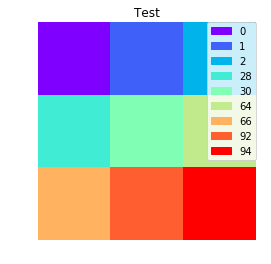

In [13]:
# Utility functions: visualizing a classified band as an image

def plot_image(image, title, figsize=(10,10)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 1, 1)
    image.imshow(ax)
    ax.set_title(title)
    ax.set_axis_off()
        
class ClassifiedImage(object):
    def __init__(self, band, labels=None):
        self.band = band
        self.labels = labels

    def imshow(self, ax, cmap='rainbow'):
        """Show classified band with colormap normalization and color legend.
        
        Alters ax in place.

        possible cmaps ref: https://matplotlib.org/examples/color/colormaps_reference.html
        """
        class_norm = _ClassNormalize(self.band)
        im = ax.imshow(self.band, cmap=cmap, norm=class_norm)

        try:
            # add class label legend
            # https://stackoverflow.com/questions/25482876
            # /how-to-add-legend-to-imshow-in-matplotlib
            color_mapping = class_norm.mapping
            colors = [im.cmap(color_mapping[k])
                      for k in self.labels.keys()]
            labels = self.labels.values()

            # https://matplotlib.org/users/legend_guide.html
            # tag: #creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
            patches = [mpatches.Patch(color=c, label=l)
                       for c,l in zip(colors, labels)]

            ax.legend(handles=patches, bbox_to_anchor=(1, 1),
                      loc='upper right', borderaxespad=0.)
        except AttributeError:
            # labels not specified
            pass


# https://matplotlib.org/users/colormapnorms.html#custom-normalization-two-linear-ranges
class _ClassNormalize(colors.Normalize):
    """Matplotlib colormap normalizer for a classified band.
    
    __init__ and __call__ are the minimum required methods.
    """
    def __init__(self, arry):
        # get unique unmasked values
        values = [v for v in np.unique(arry)
                  if not isinstance(v, np.ma.core.MaskedConstant)]

        color_ticks = np.array(range(len(values)), dtype=np.float) / (len(values) - 1)
        self._mapping = dict((v, ct)
                            for v, ct in zip(values, color_ticks))
        
        # Initialize base Normalize instance
        vmin = 0
        vmax = 1
        clip = False
        colors.Normalize.__init__(self, vmin, vmax, clip)
    
    def __call__(self, arry, clip=None):
        # round array back to ints for logical comparison
        arry = np.around(arry)
        new_arry = arry.copy()
        for k, v in self._mapping.items():
            new_arry[arry==k] = v
        return new_arry
    
    @property
    def mapping(self):
        return self._mapping

def _test():
#     classified_band = np.array(range(4)).reshape((2,2))
    classified_band = np.array([0, 1, 2, 28, 30, 64, 66, 92, 94], dtype=np.uint8).reshape((3,3))
    print(classified_band)
    labels = OrderedDict((v, str(v)) for v in np.unique(classified_band))
    classified_image = ClassifiedImage(band=classified_band, labels=labels)
    plot_image(classified_image, title='Test', figsize=(4,4))
_test()

Functionality specific to the QA Band

In [14]:
# Utility function for working with large images and memory limitations

def _read_window(filename, window):
    with rasterio.open(filename, 'r') as src:
        return src.read(window=window)

def decimated(arry, num=8):
    return arry[::num, ::num].copy()

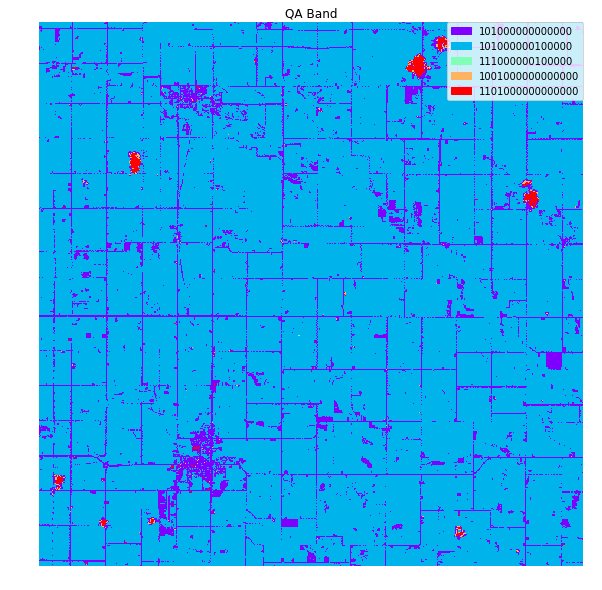

In [15]:
def load_band(band_filename, window=None):
    return _read_window(band_filename, window)[0,...]

def get_binary_labels(binary_band):
    return OrderedDict((v, '{0:b}'.format(v))
                       for v in np.unique(binary_band))

def _test():
    qa = decimated(load_band(train_l8_files['qa']))
    qa_labels = get_binary_labels(qa)
    qa_classified_band = ClassifiedImage(band=qa, labels=qa_labels)
    plot_image(qa_classified_band, title='QA Band')
_test()

In [17]:
def qa_to_mask(qa_array):
    """Generate mask from L8 QA band.
    
    The description for the information encoded in the bits in the QA is from:
    https://landsat.usgs.gov/collectionqualityband
    
    Bit 0: designated fill
    Bit 1: terrain occlusion
    Bits 2/3: radiometric saturation
    Bit 4: cloud
    Bits 5/6: cloud confidence
    Bits 7/8: cloud shadow confidence
    Bits 9/10: snow/ice confidence
    Bits 11/12: cirr

    Pixels with no issues have bits 0-4 set to 0."""
    invalid_bits = int('1111',2) # bits 0-4 are our 'invalid' bits
    bit_matches = qa_array & invalid_bits # bit-wise logical AND operator
    return bit_matches != 0 # mask any pixels that have non-zero bits 0-4

def _test():
    mask = qa_to_mask(load_band(train_l8_files['qa']))
    print'{}/{} ({:0.0f}%) masked'.format(mask.sum(), mask.size,
                                          (100.0 * mask.sum())/mask.size)
_test()

0/64000000 (0%) masked


Well, 0% masked is not terribly interesting, but it does bode well for the usefulness of this Landsat 8 scene!

## Landsat 8 and PS Orthotile Visual Images

We want to visualize the Landsat 8 and PS Orthotile RGB images.

### PS Orthotile Visual Image

#### Mask from UDM

14525797/64000000 (23%) masked


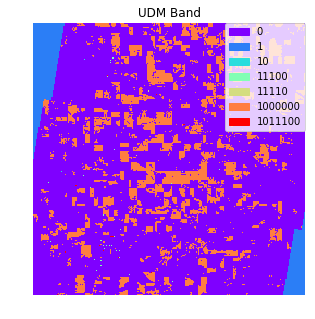

In [21]:
def udm_to_mask(udm_array):
    '''Create a mask from the udm.
    
    The description for the information encoded in the bits in the UDM is from:
    https://www.planet.com/docs/spec-sheets/sat-imagery/
    section 7.2
    
    Bit 0: blackfill
    Bit 1: cloud covered
    Bit 2: missing or suspect data in Blue band
    Bit 3: missing or suspect data in Green band
    Bit 4: missing or suspect data in Red band
    Bit 6: missing or suspect data in NIR band

    Pixels with no issues have all bits set to 0, therefore their values are zero.    
    ''' 
    return udm_array != 0

def _test():
    udm = load_band(train_files['udm'])
    mask = udm_to_mask(udm)
    print'{}/{} ({:0.0f}%) masked'.format(mask.sum(), mask.size,
                                          (100.0 * mask.sum())/mask.size)

    udm_dec = decimated(udm, 32)
    udm_labels = get_binary_labels(udm_dec)
    udm_image = ClassifiedImage(band=udm_dec, labels=udm_labels)
    plot_image(udm_image, title='UDM Band', figsize=(5,5))
_test()

#### Visual RGB

In [66]:
PSBands = namedtuple('PSBands', 'b, g, r, nir')

class PSImage(object):    
    def __init__(self, scene_filename, udm_filename, window=None):
        self.scene_filename = scene_filename
        self.udm_filename = udm_filename
        self.window = window

        self._bands = self._load_bands()
        
    def _load_bands(self):
        """Loads a 4-band BGRNir Planet Image file as a list of masked bands.

        The masked bands share the same mask, so editing one band mask will
        edit them all.
        """
        with rasterio.open(self.scene_filename, 'r') as src:
            b, g, r, nir = src.read(window=self.window)
            bands = PSBands(b=b, g=g, r=r, nir=nir)

        with rasterio.open(self.udm_filename, 'r') as src:
            udm = src.read(window=self.window)[0,...]

        mask = udm_to_mask(udm)
        return PSBands(*[np.ma.array(b, mask=mask) for b in bands])

    def rgb_bands(self):
        return [self._bands.r, self._bands.g, self._bands.b]
        
    @property
    def mask(self):
        return self._bands[0].mask
    
    @property
    def bands(self):
        return self._bands


def check_mask(img):
    band_mask = img.mask
    return '{}/{} ({:0.0f}%) masked'.format(band_mask.sum(), band_mask.size,
                                            (100.0 * band_mask.sum())/band_mask.size)

def _test():
    window = ((500,1500),(500,1500))
    print(check_mask(PSImage(train_files['scene'], train_files['udm'], window=window)))

    window = None
    print(check_mask(PSImage(train_files['scene'], train_files['udm'], window=window)))
_test()

245766/1000000 (25%) masked
14525797/64000000 (23%) masked


In [69]:
# Utility functions: displaying an rgb image

def _linear_scale(ndarray, old_min, old_max, new_min, new_max):
    """Linear scale from old_min to new_min, old_max to new_max.
    
    Values below min/max are allowed in input and output.
    Min/Max values are two data points that are used in the linear scaling.
    """
    #https://en.wikipedia.org/wiki/Normalization_(image_processing)
    return (ndarray - old_min) * (new_max - new_min) / (old_max - old_min) + new_min
# print(linear_scale(np.array([1,2,10,100,256,2560, 2660]), 2, 2560, 0, 256))


class RGBImage(object):
    def __init__(self, bands):
        # bands: list of masked bands in RGB order
        # masked bands should share the same mask
        assert len(bands) == 3
        self.bands = bands

    def imshow(self, ax, alpha=True):
        """Show RGB image with option of convering mask to alpha.
        
        Alters ax in place.

        """
        ax.imshow(self.bands_to_display(alpha=alpha))
        

    def _mask_to_alpha(self):
        band = np.atleast_3d(self.bands[0])
        alpha = np.zeros_like(band)
        alpha[~band.mask] = 1
        return alpha

    def _percentile(self, percentile):
        return np.percentile(np.concatenate([b.compressed() for b in self.bands]),
                             percentile)

    def bands_to_display(self, alpha=False):
        """Converts bands to a normalized, 3-band 3d numpy array for display."""  

        old_min = self._percentile(2)
        old_max = self._percentile(98)
        new_min = 0
        new_max = 1
        scaled = [np.clip(_linear_scale(b.astype(np.float),
                                        old_min, old_max,
                                        new_min, new_max),
                          new_min, new_max)
                  for b in self.bands]

        filled = [b.filled(fill_value=new_min) for b in scaled]

        if alpha:
            filled.append(self._mask_to_alpha())

        return np.dstack(filled)

def _test():
    img = PSImage(train_files['scene'], train_files['udm'], window=None)
    rgb_image = RGBImage([decimated(b) for b in img.rgb_bands()])
    plot_image(rgb_image, title='PS RGB', figsize=(6,6))
# _test()

### Landsat 8 Visual Image

In [70]:
L8Bands = namedtuple('L8Bands', 'b0, b1, b2, b3, b4, b5, b6, b7, b8, b9')
        
class L8Image(object):
    def __init__(self, band_filenames, qa_filename, window=None):
        self.band_filenames = band_filenames
        self.qa_filename = qa_filename
        self.window = window

        self._bands = self._load_bands()
    
    def _load_mask(self):
        qa = self._read_band(self.qa_filename)
        return qa_to_mask(qa)
        
    def _load_bands(self):
        def _try_read_band(band_name, mask):
            try:
                filename = self.band_filenames[band_name]
                band_arry = self._read_band(filename)
                band = np.ma.array(band_arry, mask=mask)
            except KeyError:
                # band_name not a key in band_filenames
                band = None
            return band

        mask = self._load_mask()
        return L8Bands(*[_try_read_band(band_name, mask)
                         for band_name in L8Bands._fields])
    
    def _read_band(self, filename):
        with rasterio.open(filename, 'r') as src:
            band = src.read(window=self.window)[0,...]
        return band
    
    def rgb_bands(self):
        rgb_bands = [self._bands.b4, self._bands.b3, self._bands.b2]
        return rgb_bands

    @property
    def mask(self):
        return self._bands[0].mask
    
    @property
    def bands(self):
        return self._bands

def _test():
    # RGB bands in order : b4, b3, b2
    rgb_bandnames = ['b4', 'b3', 'b2']
    rgb_files = dict([(k, train_l8_files[k])
                         for k in rgb_bandnames])
    img = L8Image(rgb_files, train_l8_files['qa'], window=None)
    rgb_image = RGBImage([decimated(b) for b in img.rgb_bands()])
    plot_image(rgb_image, title='L8 RGB', figsize=(6,6))
# _test()

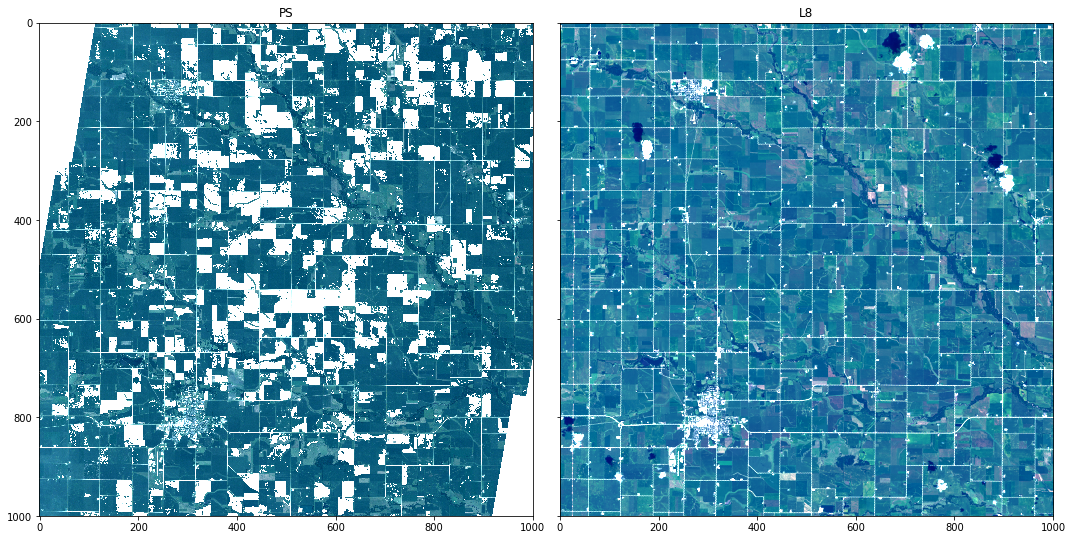

In [73]:
def plot_rgb_comparison(ps_files, l8_files, figsize=(15,15)):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,
                                   sharex=True, sharey=True,
                                   figsize=figsize)

    # L8
    rgb_bandnames = ['b4', 'b3', 'b2']
    rgb_files = dict([(k, train_l8_files[k])
                         for k in rgb_bandnames])
    l8_img = L8Image(rgb_files, train_l8_files['qa'], window=None)
    l8_rgb_image = RGBImage([decimated(b) for b in l8_img.rgb_bands()])
    
    for ax in (ax1, ax2):
        ax.set_adjustable('box-forced')

    # PS
    img = PSImage(ps_files['scene'], ps_files['udm'], window=None)
    ps_rgb_image = RGBImage([decimated(b) for b in img.rgb_bands()])
    ps_rgb_image.imshow(ax1)
    ax1.set_title('PS')

    # L8
    rgb_bandnames = ['b4', 'b3', 'b2']
    rgb_files = dict([(k, l8_files[k]) for k in rgb_bandnames])
    l8_img = L8Image(rgb_files, l8_files['qa'], window=None)
    l8_rgb_image = RGBImage([decimated(b) for b in l8_img.rgb_bands()])
    l8_rgb_image.imshow(ax2)
    ax2.set_title('L8')
    plt.tight_layout()

plot_rgb_comparison(train_files, train_l8_files)